In [19]:
import torch
torch.cuda.is_available()

True

<h1>Install and Import Libraries</h1>

In [20]:
!pip install -q transformers datasets torchaudio librosa seaborn

In [21]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

<h1>Load Dataset</h1>

In [22]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2026-01-03 06:56:01--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2026-01-03 06:56:01--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip.1’

Audio_Speech_Actors 100%[===================>] 198.81M  1.15MB/s    in 3m 23s  

2026-01-03 06:59:24 (1004 KB/s) - ‘Audio_Speech_Actors_01-24.zip.1’ saved [208468073/208468073]



In [23]:
!unzip Audio_Speech_Actors_01-24.zip

Archive:  Audio_Speech_Actors_01-24.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03

In [24]:
import os
os.listdir("/content")

['.config',
 'Audio_Speech_Actors_01-24.zip',
 'Actor_11',
 'Actor_22',
 'drive',
 'Audio_Speech_Actors_01-24.zip.1',
 'Actor_21',
 'Actor_23',
 'Actor_20',
 'Actor_24',
 'Actor_08',
 'Actor_07',
 'Actor_17',
 'Actor_15',
 'Actor_06',
 'Actor_19',
 'Actor_09',
 'Actor_04',
 'Actor_02',
 'Actor_12',
 'Actor_16',
 'Actor_14',
 'Actor_18',
 'Actor_05',
 'data_path.csv',
 'Actor_03',
 'Actor_01',
 'Actor_13',
 'Actor_10',
 'sample_data']

In [25]:
Ravdess = "/content/"

In [26]:
import os
import pandas as pd

Ravdess = "/content/"

# ONLY actor folders
ravdess_directory_list = [
    d for d in os.listdir(Ravdess)
    if d.startswith("Actor_")
]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_path = os.path.join(Ravdess, dir)

    for file in os.listdir(actor_path):
        # ONLY wav files
        if not file.endswith(".wav"):
            continue

        part = file.split('.')[0].split('-')

        # RAVDESS files MUST have 7 parts
        if len(part) < 3:
            continue

        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(actor_path, file))

# Create DataFrame
Ravdess_df = pd.DataFrame({
    "Emotions": file_emotion,
    "Path": file_path
})

# Map emotion labels
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].replace({
    1:'neutral', 2:'calm', 3:'happy', 4:'sad',
    5:'angry', 6:'fear', 7:'disgust', 8:'surprise'
})

Ravdess_df.head()

,Emotions,Path
0,sad,/content/Actor_11/03-01-04-02-02-01-11.wav
1,sad,/content/Actor_11/03-01-04-01-02-01-11.wav
2,surprise,/content/Actor_11/03-01-08-02-01-01-11.wav
3,neutral,/content/Actor_11/03-01-01-01-02-01-11.wav
4,calm,/content/Actor_11/03-01-02-01-02-02-11.wav


In [27]:
# creating Dataframe.
df = pd.concat([Ravdess_df], axis = 0)
df.to_csv("data_path.csv",index=False)
df.head()

,Emotions,Path
0,sad,/content/Actor_11/03-01-04-02-02-01-11.wav
1,sad,/content/Actor_11/03-01-04-01-02-01-11.wav
2,surprise,/content/Actor_11/03-01-08-02-01-01-11.wav
3,neutral,/content/Actor_11/03-01-01-01-02-01-11.wav
4,calm,/content/Actor_11/03-01-02-01-02-02-11.wav


In [28]:
df = pd.read_csv("data_path.csv")

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Emotions"])

NUM_CLASSES = df["label"].nunique()
print("Classes:", label_encoder.classes_)

Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


<h1>Dataset Loader (RAW WAV --> wav2vec2)</h1>

In [29]:
# class SERDataset(Dataset):
#     def __init__(self, df, processor, max_len=16000*4):
#         self.df = df.reset_index(drop=True)
#         self.processor = processor
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         path = self.df.loc[idx, "Path"]
#         label = self.df.loc[idx, "label"]

#         speech, sr = torchaudio.load(path)
#         speech = speech.squeeze()

#         if sr != 16000:
#             speech = torchaudio.functional.resample(speech, sr, 16000)

#         inputs = self.processor(
#             speech,
#             sampling_rate=16000,
#             padding="max_length",
#             truncation=True,
#             max_length=self.max_len,
#             return_tensors="pt"
#         )

#         return inputs.input_values.squeeze(), torch.tensor(label)

In [30]:
import soundfile as sf
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class SERDataset(Dataset):
    def __init__(self, df, processor, max_len=16000*4):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_len = max_len
        self.target_sr = 16000

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Path"]
        label = self.df.loc[idx, "label"]

        # LOAD AUDIO (NO TORCHAUDIO)
        speech, sr = sf.read(path)
        speech = torch.tensor(speech, dtype=torch.float32)

        # mono conversion
        if speech.ndim > 1:
            speech = speech.mean(dim=1)

        # RESAMPLE (NO TORCHAUDIO)
        if sr != self.target_sr:
            speech = F.interpolate(
                speech.unsqueeze(0).unsqueeze(0),
                size=int(len(speech) * self.target_sr / sr),
                mode="linear",
                align_corners=False
            ).squeeze()

        # wav2vec2 processing
        inputs = self.processor(
            speech.numpy(),
            sampling_rate=self.target_sr,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return inputs.input_values.squeeze(0), torch.tensor(label, dtype=torch.long)

<h1>wav2vec2 + BiLSTM + Attention</h1>

In [31]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        return torch.sum(weights * x, dim=1)

In [32]:
class SERModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        for param in self.wav2vec.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=768,r
            # input_size=1024,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.attention = Attention(256)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.wav2vec(x).last_hidden_state

        lstm_out, _ = self.lstm(features)
        attn_out = self.attention(lstm_out)
        return self.classifier(attn_out)

<h1>DataLoader Setup</h1>

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

train_ds = SERDataset(train_df, processor)
test_ds = SERDataset(test_df, processor)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4)

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


<h1>Training Loop</h1>

In [34]:
!pip install soundfile

import soundfile as sf
import torch

def load_audio(path):
    waveform, sample_rate = sf.read(path)
    waveform = torch.tensor(waveform, dtype=torch.float32)

    # convert mono if stereo
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=1)

    return waveform, sample_rate

In [35]:
model = SERModel(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {running_loss/len(train_loader):.4f}")

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch [1/20] | Loss: 1.8881
Epoch [2/20] | Loss: 1.6990
Epoch [3/20] | Loss: 1.5193
Epoch [4/20] | Loss: 1.3491
Epoch [5/20] | Loss: 1.2527
Epoch [6/20] | Loss: 1.1438
Epoch [7/20] | Loss: 1.0334
Epoch [8/20] | Loss: 1.0128
Epoch [9/20] | Loss: 0.9409
Epoch [10/20] | Loss: 0.8478
Epoch [11/20] | Loss: 0.8158
Epoch [12/20] | Loss: 0.7554
Epoch [13/20] | Loss: 0.7088
Epoch [14/20] | Loss: 0.7047
Epoch [15/20] | Loss: 0.6559
Epoch [16/20] | Loss: 0.5706
Epoch [17/20] | Loss: 0.5793
Epoch [18/20] | Loss: 0.4991
Epoch [19/20] | Loss: 0.4901
Epoch [20/20] | Loss: 0.4665


Evaluation (Accuracy + Metrics)

In [36]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(y.numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [37]:
y_true, y_pred = evaluate(model, test_loader)

Accuracy

In [38]:
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 68.06%


Classification Report

In [39]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=label_encoder.classes_
    )
)

              precision    recall  f1-score   support

       angry       0.79      0.71      0.75        38
        calm       0.68      0.61      0.64        38
     disgust       0.75      0.71      0.73        38
        fear       0.79      0.87      0.83        39
       happy       0.83      0.38      0.53        39
     neutral       0.43      0.68      0.53        19
         sad       0.57      0.84      0.68        38
    surprise       0.68      0.64      0.66        39

    accuracy                           0.68       288
   macro avg       0.69      0.68      0.67       288
weighted avg       0.71      0.68      0.68       288



Confusion Matrix

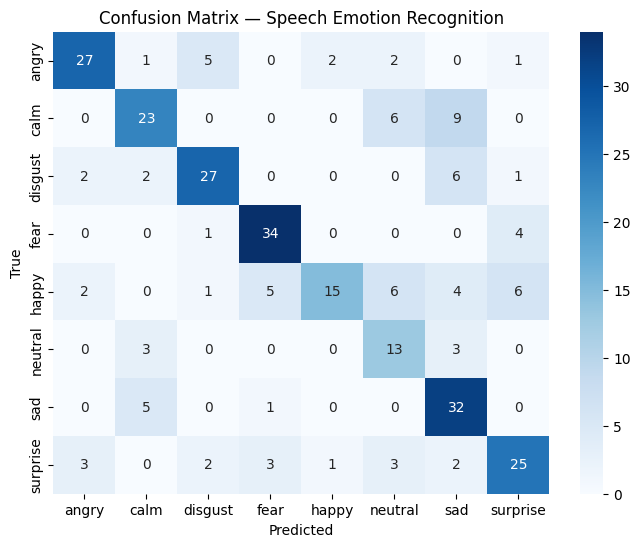

In [40]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Speech Emotion Recognition")
plt.show()

In [41]:
import torch

torch.save(model.state_dict(), "speech_emotion_wav2vec2_base_model.pth")

In [42]:
model = SERModel(NUM_CLASSES)
model.load_state_dict(
    torch.load("speech_emotion_wav2vec2_base_model.pth", map_location="cpu")
)
model.eval()

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


SERModel(
  (wav2vec): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Wav2V